## 模型泛化
* 可调整参数的数量。当可调整参数的数量（有时称为自由度）很大时，模型往往更容易过拟合。
* 参数采用的值。当权重的取值范围较大时，模型可能更容易过拟合。
* 训练样本的数量。即使模型很简单，也很容易过拟合只包含一两个样本的数据集。而过拟合一个有数百
万个样本的数据集则需要一个极其灵活的模型。

### 验证集
原则上，在我们确定所有的超参数之前，我们不希望用到测试集。
解决此问题的常见做法是将我们的数据分成三份，除了训练和测试数据集之外，还增加一个验证数据集（validation dataset），也叫验证集（validation set）。

#### 训练误差
这是模型在训练数据集上的误差。换句话说，它衡量的是模型在已经见过的数据上的表现。
#### 验证误差
这是模型在验证数据集上的误差。验证数据集通常是从原始训练数据集中分离出来的，模型在训练过程中并没有使用它。它用于评估模型对未见过的数据的泛化能力。

### K折交叉验证
将原始训练数据被分成K个不重叠的子集，然后执行K次模型训练和验证。
每次在K − 1个子集上进行训练，并在剩余的一个子集（在该轮中没有用于训练的子集）上进行验证。
最后，通过对K次实验的结果取平均来估计训练和验证误差。

In [8]:
# 多项式回归

import math
import numpy as np
import torch
from torch import nn
from utils.fashion_mnist import *

In [9]:
# 生成多项式的数据集样本
max_degree = 20 # 多项式最大阶数
n_train, n_test = 100, 100 # 训练集和测试数据集的大小
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6]) # 20阶多项式，但只有前四项系数非零

features = np.random.normal(size=(n_test + n_train, 1))
np.random.shuffle(features)

# 计算features数组的每个元素的幂。
# 此功能可以接受两个数组，并返回一个数组，其中每个元素是第一个数组中对应元素的第二个数组中对应元素的幂。
# 相当于吧features中每一个元素的0次幂到max_degress-1次幂的结果作为结果的一行，对features所有元素进行这样的处理
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))

for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # gamma(n)=(n-1)!
# labels的维度: (n_train + n_test, )
# poly_features维度为[n_test + n_train, max_degree]
# true_w维度为[max_degress, 1]
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

# NumPy数组转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) 
                                           for x in [true_w, features, poly_features, labels]]
features[:2], poly_features[:2, :], labels[:2] # 输出前两个元素

(tensor([[ 1.0075],
         [-0.9383]]),
 tensor([[ 1.0000e+00,  1.0075e+00,  5.0751e-01,  1.7043e-01,  4.2927e-02,
           8.6496e-03,  1.4524e-03,  2.0903e-04,  2.6325e-05,  2.9468e-06,
           2.9689e-07,  2.7192e-08,  2.2829e-09,  1.7692e-10,  1.2732e-11,
           8.5513e-13,  5.3845e-14,  3.1911e-15,  1.7861e-16,  9.4706e-18],
         [ 1.0000e+00, -9.3834e-01,  4.4025e-01, -1.3770e-01,  3.2303e-02,
          -6.0622e-03,  9.4807e-04, -1.2709e-04,  1.4907e-05, -1.5542e-06,
           1.4583e-07, -1.2440e-08,  9.7277e-10, -7.0215e-11,  4.7061e-12,
          -2.9440e-13,  1.7265e-14, -9.5299e-16,  4.9680e-17, -2.4535e-18]]),
 tensor([5.5299, 1.5170]))

In [10]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上的模型的损失"""
    metric = Accumulator(2) # 损失总和，样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [11]:
# 训练函数
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    
    # 不设置偏置，因为在多项式中实现了
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    
    batch_size = min(10, train_labels.shape[0])
    train_iter = load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    
    optim = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = Animator(xlabel='epoch', ylabel='loss', yscale='log',
                        xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                        legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, optim)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    
    print(f'weight: {net[0].weight.data.numpy()}')

weight: [[ 5.0057454  1.202635  -3.4115732  5.591734 ]]


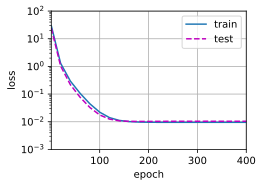

In [5]:
# 只从多项式特征中选取前四个维度
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.3534927 4.3374763]]


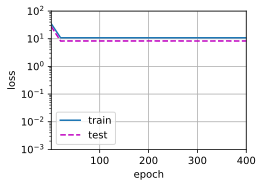

In [6]:
# 线性函数拟合，即只选取0阶和1阶，欠拟合
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9694557   1.2852217  -3.2915976   5.082451   -0.38738352  1.6037021
   0.2528131   0.1842097  -0.10945991 -0.03394744 -0.16631204  0.07286068
  -0.07953456  0.010931    0.02567809 -0.11564837  0.17393118  0.10956258
  -0.08516017  0.21155557]]


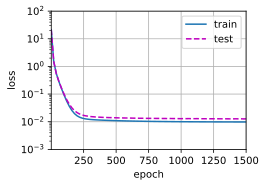

In [12]:
# 高阶多项式函数拟合，使用全部max_degree，过拟合，需要提高训练轮数
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)
# 不知道为什么，测试误差没有非常高

## 总结
* 欠拟合：模型表达能力不足，无法通过继续训练减少训练误差。
* 过拟合：训练误差可能会很低，但验证误差可能会较高。
* 验证集用于模型选择，不能过于随意使用。可能会导致验证集数据泄漏到模型中，或模型过拟合验证集，降低泛化能力的可信度
* 训练模型应该选择复杂度适中的，避免使用数量不足的训练样本

i=0
step: 0, train_loss: 22.04496212387085, test_loss: 41.37917860031128
i=1
step: 1, train_loss: 8.087140201568603, test_loss: 17.51091983795166
i=2
step: 2, train_loss: 3.5705884647369386, test_loss: 13.671390829086304
i=3
step: 3, train_loss: 0.010154345728456974, test_loss: 0.01255325112491846
i=4
step: 4, train_loss: 0.010140445552766324, test_loss: 0.012762484923005104
i=5
step: 5, train_loss: 0.01015715653821826, test_loss: 0.013893163315951824
i=6
step: 6, train_loss: 0.010136595815420152, test_loss: 0.013875489085912705
i=7
step: 7, train_loss: 0.01013938851095736, test_loss: 0.014173643961548806
i=8
step: 8, train_loss: 0.010154812123626471, test_loss: 0.013120261207222938
i=9
step: 9, train_loss: 0.010154141172766685, test_loss: 0.013940363004803658
i=10
step: 10, train_loss: 0.010155606964603067, test_loss: 0.013517398051917554
i=11
step: 11, train_loss: 0.01014604064822197, test_loss: 0.013399400934576988
i=12
step: 12, train_loss: 0.010147319784387945, test_loss: 0.013406

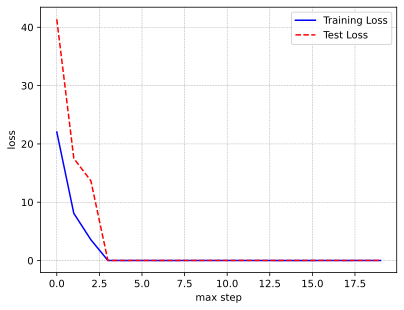

In [24]:
# 绘制不同模型复杂度下的训练和测试损失图像

# 生成更多训练和测试数据
max_degree = 20
n_train, n_test = 1000, 100 # 训练集和测试数据集的大小
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_test + n_train, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # gamma(n)=(n-1)!
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) 
                                           for x in [true_w, features, poly_features, labels]]


# 训练和测试函数
def train(train_features, test_features, train_labels, test_labels, num_epochs=1200):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    
    batch_size = min(10, train_labels.shape[0])
    train_iter = load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    
    optim = torch.optim.SGD(net.parameters(), lr=0.01)
    
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, optim)
        
    return evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)

result = []
for i in range(1, max_degree + 1): # [1, 20]
    print(f'i={i-1}')
    train_loss, test_loss = train(poly_features[:n_train, :i], poly_features[n_train:, :i], 
                                  labels[:n_train], labels[n_train:])
    print(f'step: {i-1}, train_loss: {train_loss}, test_loss: {test_loss}')
    result.append([i-1, train_loss, test_loss])

import matplotlib.ticker as ticker
def plot_loss(data):
    i_values = [item[0] for item in data]
    train_losses = [item[1] for item in data]
    test_losses = [item[2] for item in data]
    
    plt.plot(i_values, train_losses, '-b', label='Training Loss')
    plt.plot(i_values, test_losses, '--r', label='Test Loss')
    
    plt.xlabel('max step')
    plt.ylabel('loss')
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    
    plt.show()
    
plot_loss(result)

1. 模型复杂度与过拟合/欠拟合：
* 过拟合：当模型过于复杂时，例如具有太多的参数或者使用了复杂的非线性结构，它可能会过度地学习训练数据中的特征，包括数据的噪声。这会导致模型在训练数据上表现得很好，但在新的、未见过的数据上可能表现不佳。
* 欠拟合：当模型过于简单，例如参数太少或者结构太简单，它可能无法捕捉到数据中的所有相关特征和模式。这会导致模型在训练数据和新数据上都表现不佳。

2. 训练轮数与过拟合/欠拟合：
* 过拟合：即使模型结构适中，如果训练轮数过多，模型仍可能过度拟合训练数据。这是因为随着训练轮数的增加，模型可能开始学习训练数据中的噪声和非代表性特征。
* 欠拟合：如果训练轮数太少，即使模型的复杂度适当，模型可能还没有足够的机会学习数据中的特征和模式，从而导致欠拟合。